In [1]:
from __future__ import print_function
import os
data_path = ['data']

In [2]:
import pandas as pd
import numpy as np
#Get columns names from dataset website
columns = ['Sequence Name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'Classification']

# Import the data
filepath = os.sep.join(data_path + ['ecoli.data'])
data = pd.read_csv(filepath, sep='\s+', names=columns)

data.sample(5)

,Sequence Name,mcg,gvh,lip,chg,aac,alm1,alm2,Classification
236,FEPD_ECOLI,0.84,0.49,0.48,0.5,0.55,0.78,0.74,imU
110,SOXS_ECOLI,0.32,0.33,0.48,0.5,0.60,0.06,0.20,cp
123,SYL_ECOLI,0.04,0.31,0.48,0.5,0.41,0.29,0.39,cp
105,RNC_ECOLI,0.26,0.50,0.48,0.5,0.44,0.32,0.41,cp
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp


In [3]:
data['Sequence Name'].value_counts()

AAT_ECOLI     1
NFRB_ECOLI    1
CRED_ECOLI    1
CPXA_ECOLI    1
CAIT_ECOLI    1
             ..
SOXS_ECOLI    1
SLYD_ECOLI    1
SERC_ECOLI    1
RNE_ECOLI     1
YTFQ_ECOLI    1
Name: Sequence Name, Length: 336, dtype: int64

In [4]:
#Drop irrelevant feature
data = data.drop('Sequence Name', axis = 1)

In [5]:
print(data['lip'].value_counts())
print(data['chg'].value_counts())

0.48    326
1.00     10
Name: lip, dtype: int64
0.5    335
1.0      1
Name: chg, dtype: int64


In [6]:
#lip and chg are unusable due to almost all values the same

data = data.drop('lip', axis = 1)
data = data.drop('chg', axis = 1)

data.sample(5)

,mcg,gvh,aac,alm1,alm2,Classification
93,0.30,0.45,0.36,0.21,0.32,cp
15,0.25,0.40,0.46,0.44,0.52,cp
204,0.31,0.44,0.50,0.79,0.82,im
237,0.77,0.55,0.51,0.78,0.74,imU
113,0.38,0.30,0.43,0.29,0.39,cp


In [7]:
data['Classification'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: Classification, dtype: int64

In [8]:
#Not enough of these classification to accurately predict if a sample will fall
#in to them so it is better to remove them to reduce noise
data = data[data['Classification'] != 'imL']
data = data[data['Classification'] != 'imS']
data = data[data['Classification'] != 'omL']
data['Classification'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
Name: Classification, dtype: int64

In [9]:
features = data.columns[:-1]
labels = data.Classification
print(features.tolist())
labels

['mcg', 'gvh', 'aac', 'alm1', 'alm2']


0      cp
1      cp
2      cp
3      cp
4      cp
       ..
331    pp
332    pp
333    pp
334    pp
335    pp
Name: Classification, Length: 327, dtype: object

In [10]:
#Calculate skew larger than 75%
skew_cols = (data[features].skew().sort_values(ascending=False))
skew_cols = skew_cols.loc[skew_cols > 0.75]
skew_cols

gvh    0.770661
dtype: float64

In [11]:
#Generate corr matrix
corr_mat = data[features].corr(numeric_only=True)

for x in range(len(data[features].columns)):
    corr_mat.iloc[x,x] = 0.0

corr_mat

,mcg,gvh,aac,alm1,alm2
mcg,0.000000,0.462374,0.224083,0.394932,0.197276
gvh,0.462374,0.000000,0.071957,0.178326,-0.114158
aac,0.224083,0.071957,0.000000,0.279218,0.260667
alm1,0.394932,0.178326,0.279218,0.000000,0.828592
alm2,0.197276,-0.114158,0.260667,0.828592,0.000000


In [12]:
from sklearn.preprocessing import StandardScaler

#To fix skew
for col in skew_cols.index.tolist():
    data[col]=np.log1p(data[col])

#Scaling
ss = StandardScaler()
data[features] = ss.fit_transform(data[features])

data.head(5)

,mcg,gvh,aac,alm1,alm2,Classification
0,-0.021660,-1.503119,0.492374,-1.186456,-0.741030,cp
1,-2.193077,-0.660563,0.329741,-0.679545,-0.305470,cp
2,0.340242,-0.660563,-0.076840,-0.587380,-0.208678,cp
3,0.495344,-0.019057,0.167109,-0.218717,-0.692634,cp
4,-1.365871,-1.266409,0.411058,-1.140373,-0.741030,cp


In [13]:
#Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {'max_depth': np.arange(4, 8),"criterion":['gini','entropy'],
              "max_features":np.arange(2,5),"min_samples_split": np.arange(2,6)}
#Grid Search to find best Decision Tree
dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5,scoring ="accuracy",
                  return_train_score=True)

dtc.fit(data[features], labels)
print(dtc.best_estimator_)
feature_importances = dtc.best_estimator_.feature_importances_

feature_importances_array = np.array(list(zip(features.tolist(), feature_importances)))
feature_importances_array.tolist()

DecisionTreeClassifier(max_depth=6, max_features=3, min_samples_split=5,
                       random_state=42)


[['mcg', '0.14706678642643725'],
 ['gvh', '0.29131767891977284'],
 ['aac', '0.11995687321969507'],
 ['alm1', '0.4091851922350612'],
 ['alm2', '0.03247346919903366']]

In [14]:
#Analysis of best Decision Tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(data[features], labels, test_size=0.2, stratify=labels, random_state=42)
best_dtc = dtc.best_estimator_
best_dtc.fit(X_train, y_train)
y_pred = best_dtc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          cp       0.90      0.93      0.92        29
          im       0.83      0.62      0.71        16
         imU       0.43      0.86      0.57         7
          om       0.60      0.75      0.67         4
          pp       1.00      0.50      0.67        10

    accuracy                           0.77        66
   macro avg       0.75      0.73      0.71        66
weighted avg       0.83      0.77      0.78        66



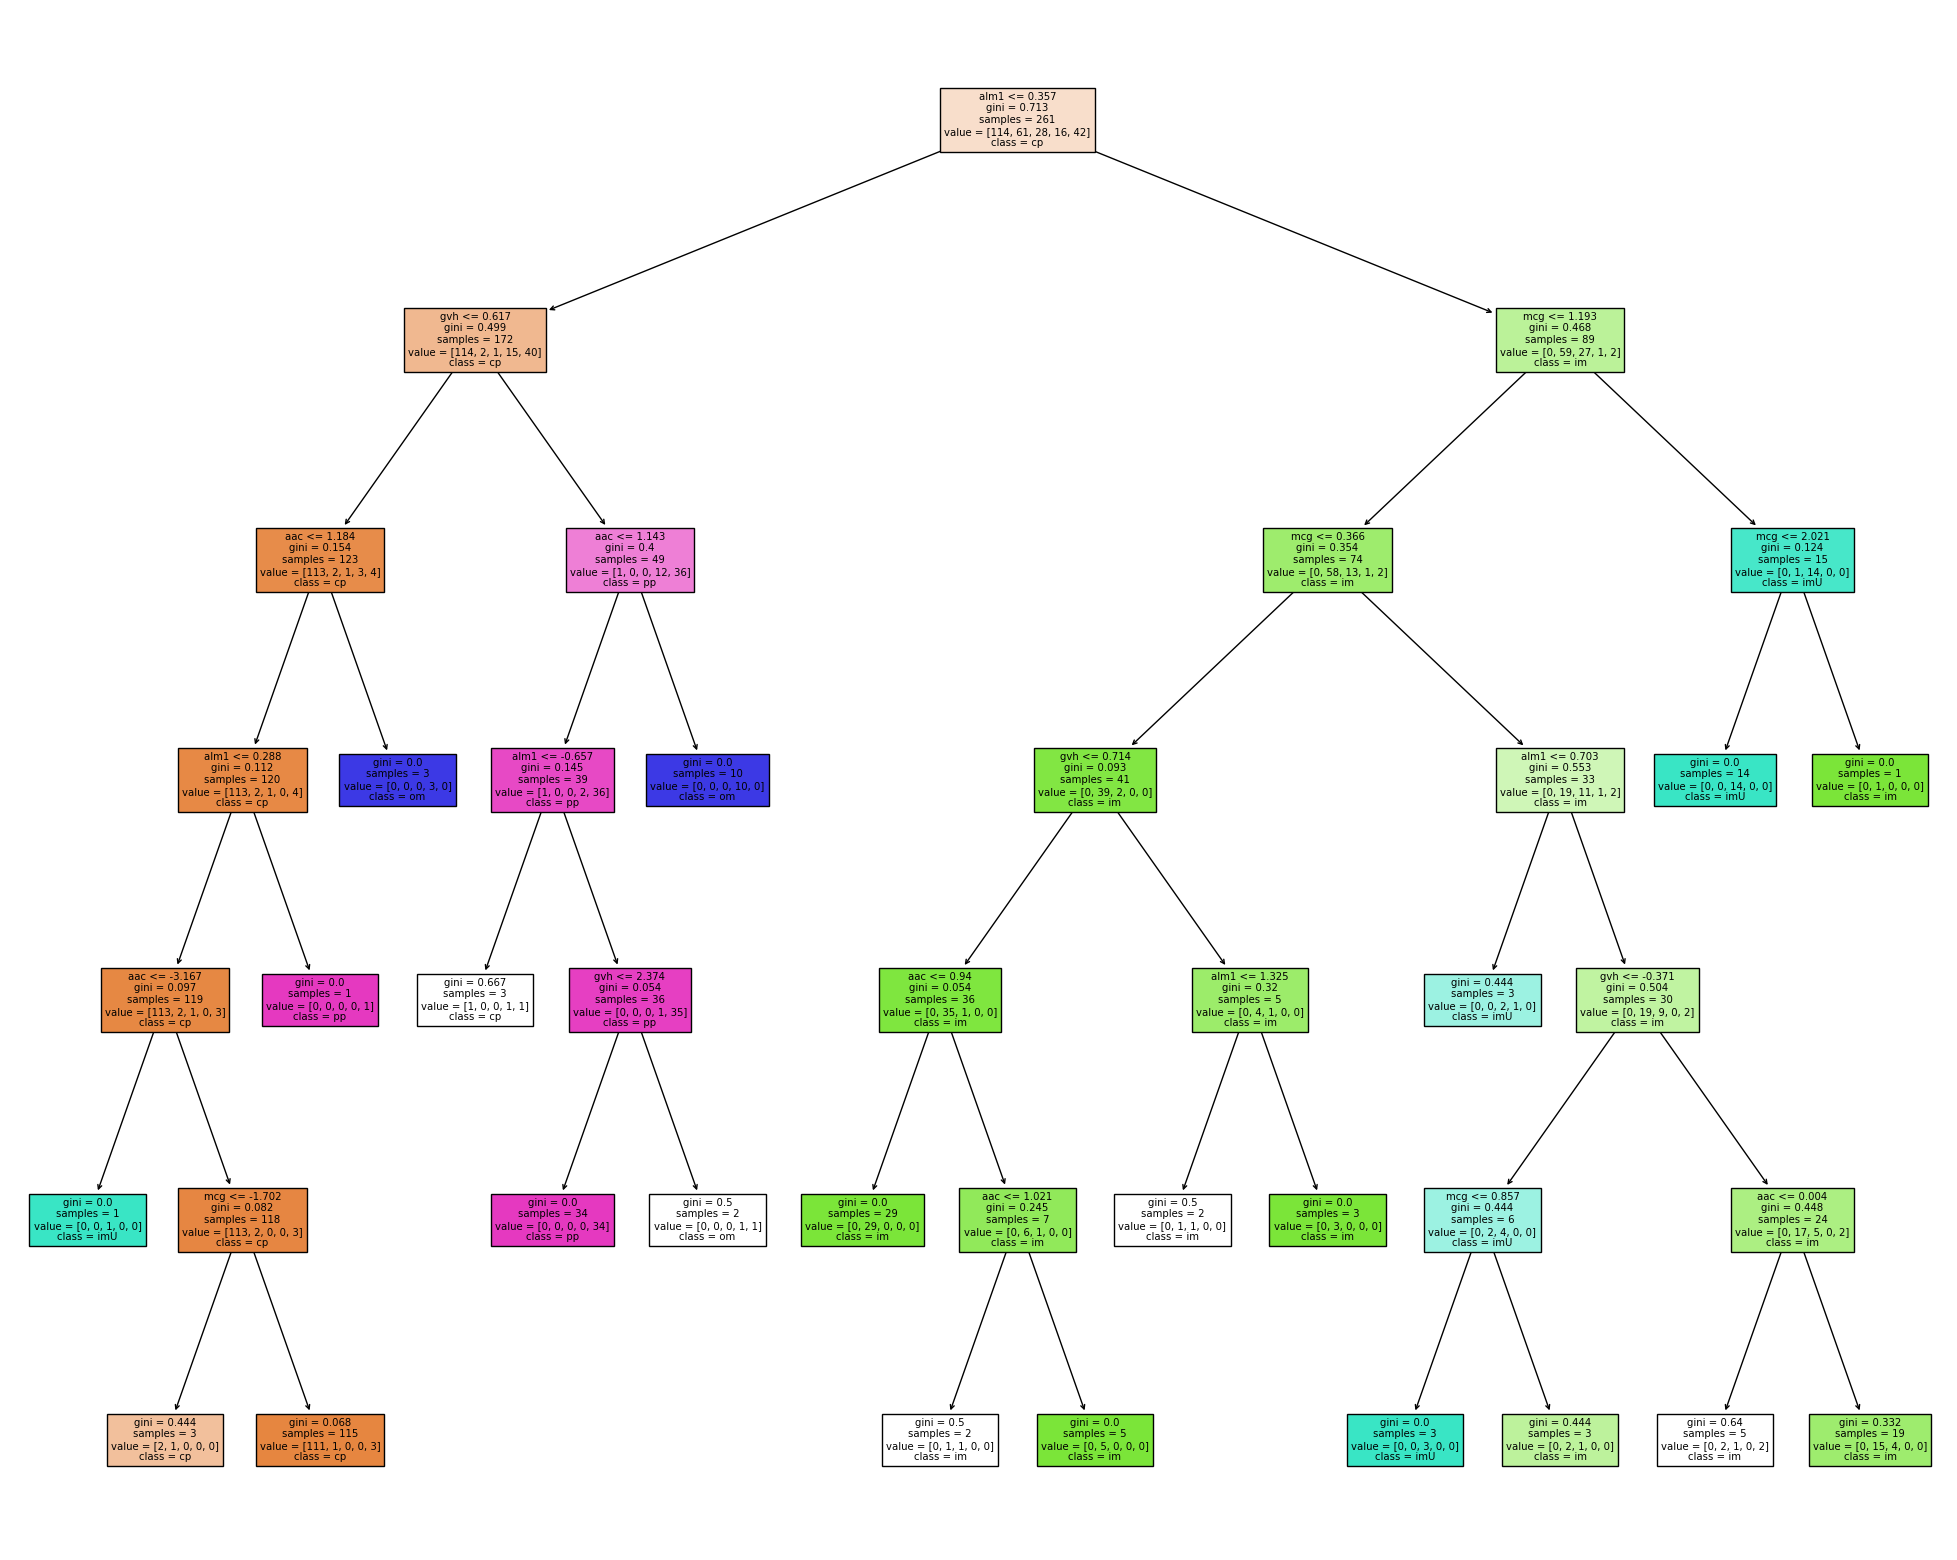

In [15]:
#Quick visualization of Decision Tree
from sklearn import tree
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dtc, 
                   feature_names=features.tolist(),  
                   class_names=best_dtc.classes_,
                   filled=True)

In [16]:
#K-Means clustering
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

#From classification
n_clusters=labels.nunique()

km = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
km = km.fit(data[features])

data['kmeans'] = km.predict(data[features])

(data[['Classification', 'kmeans']].groupby(['Classification', 'kmeans']).size()
                                   .to_frame().rename(columns={0:'number'}))

number
Classification kmeans        
cp             0            7
               1          135
               4            1
im             0            2
               1            6
               2           29
               4           40
imU            0            1
               2           32
               4            2
om             0            1
               3           19
pp             0           45
               1            2
               2            1
               3            3
               4            1

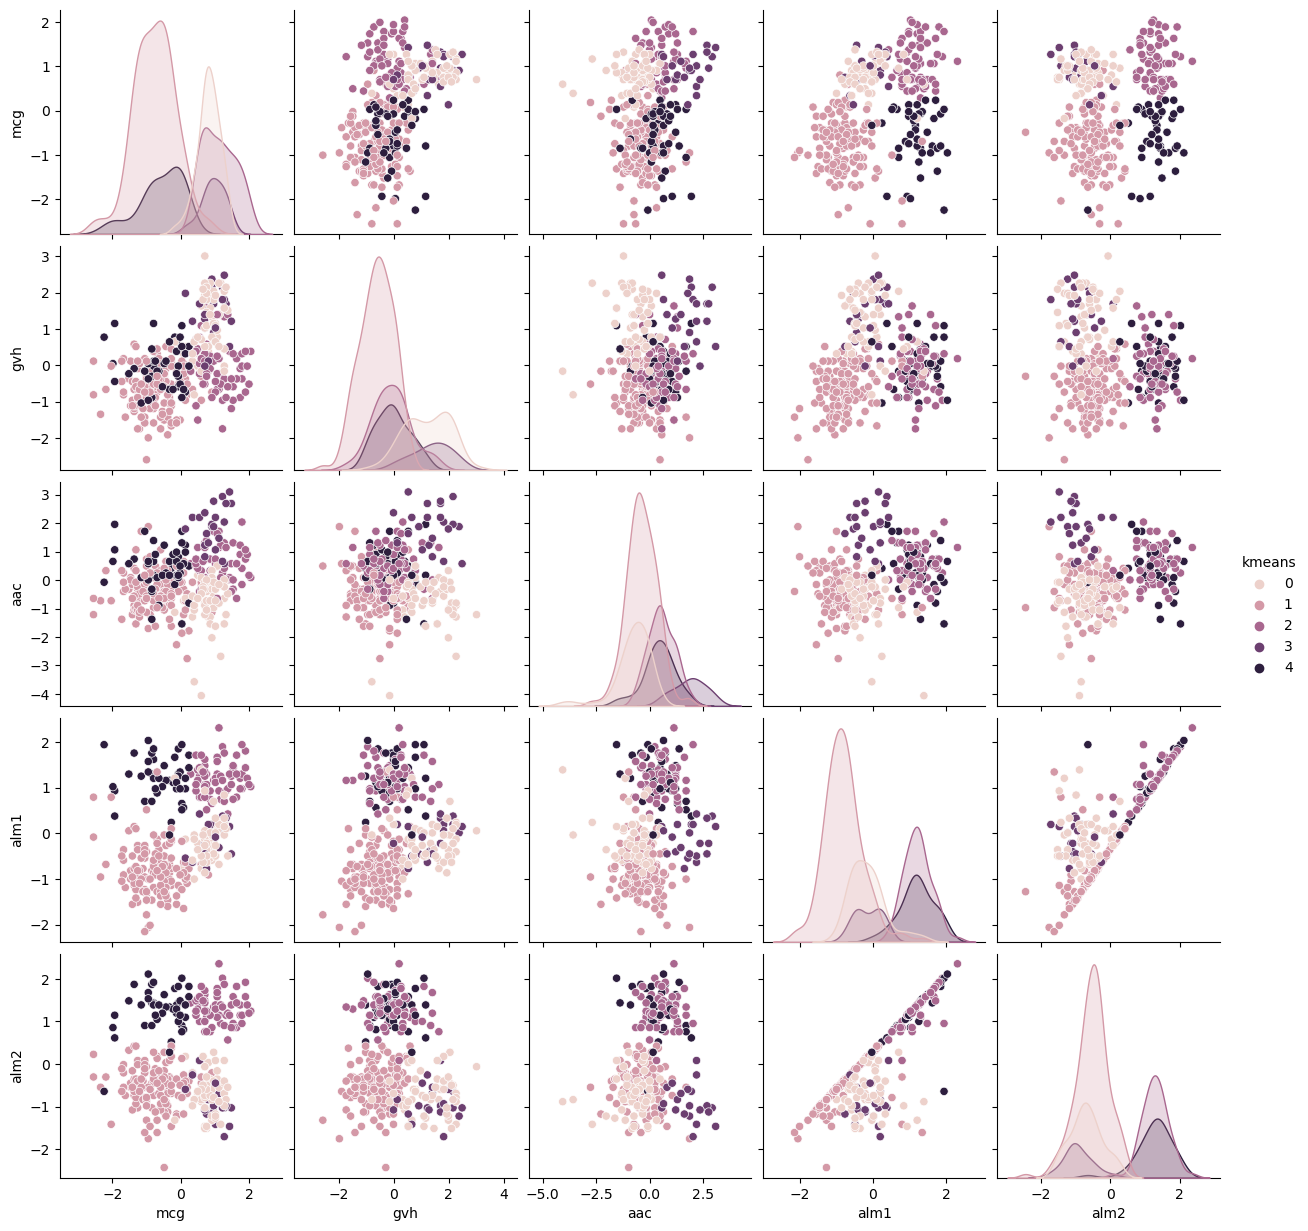

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data, hue='kmeans');

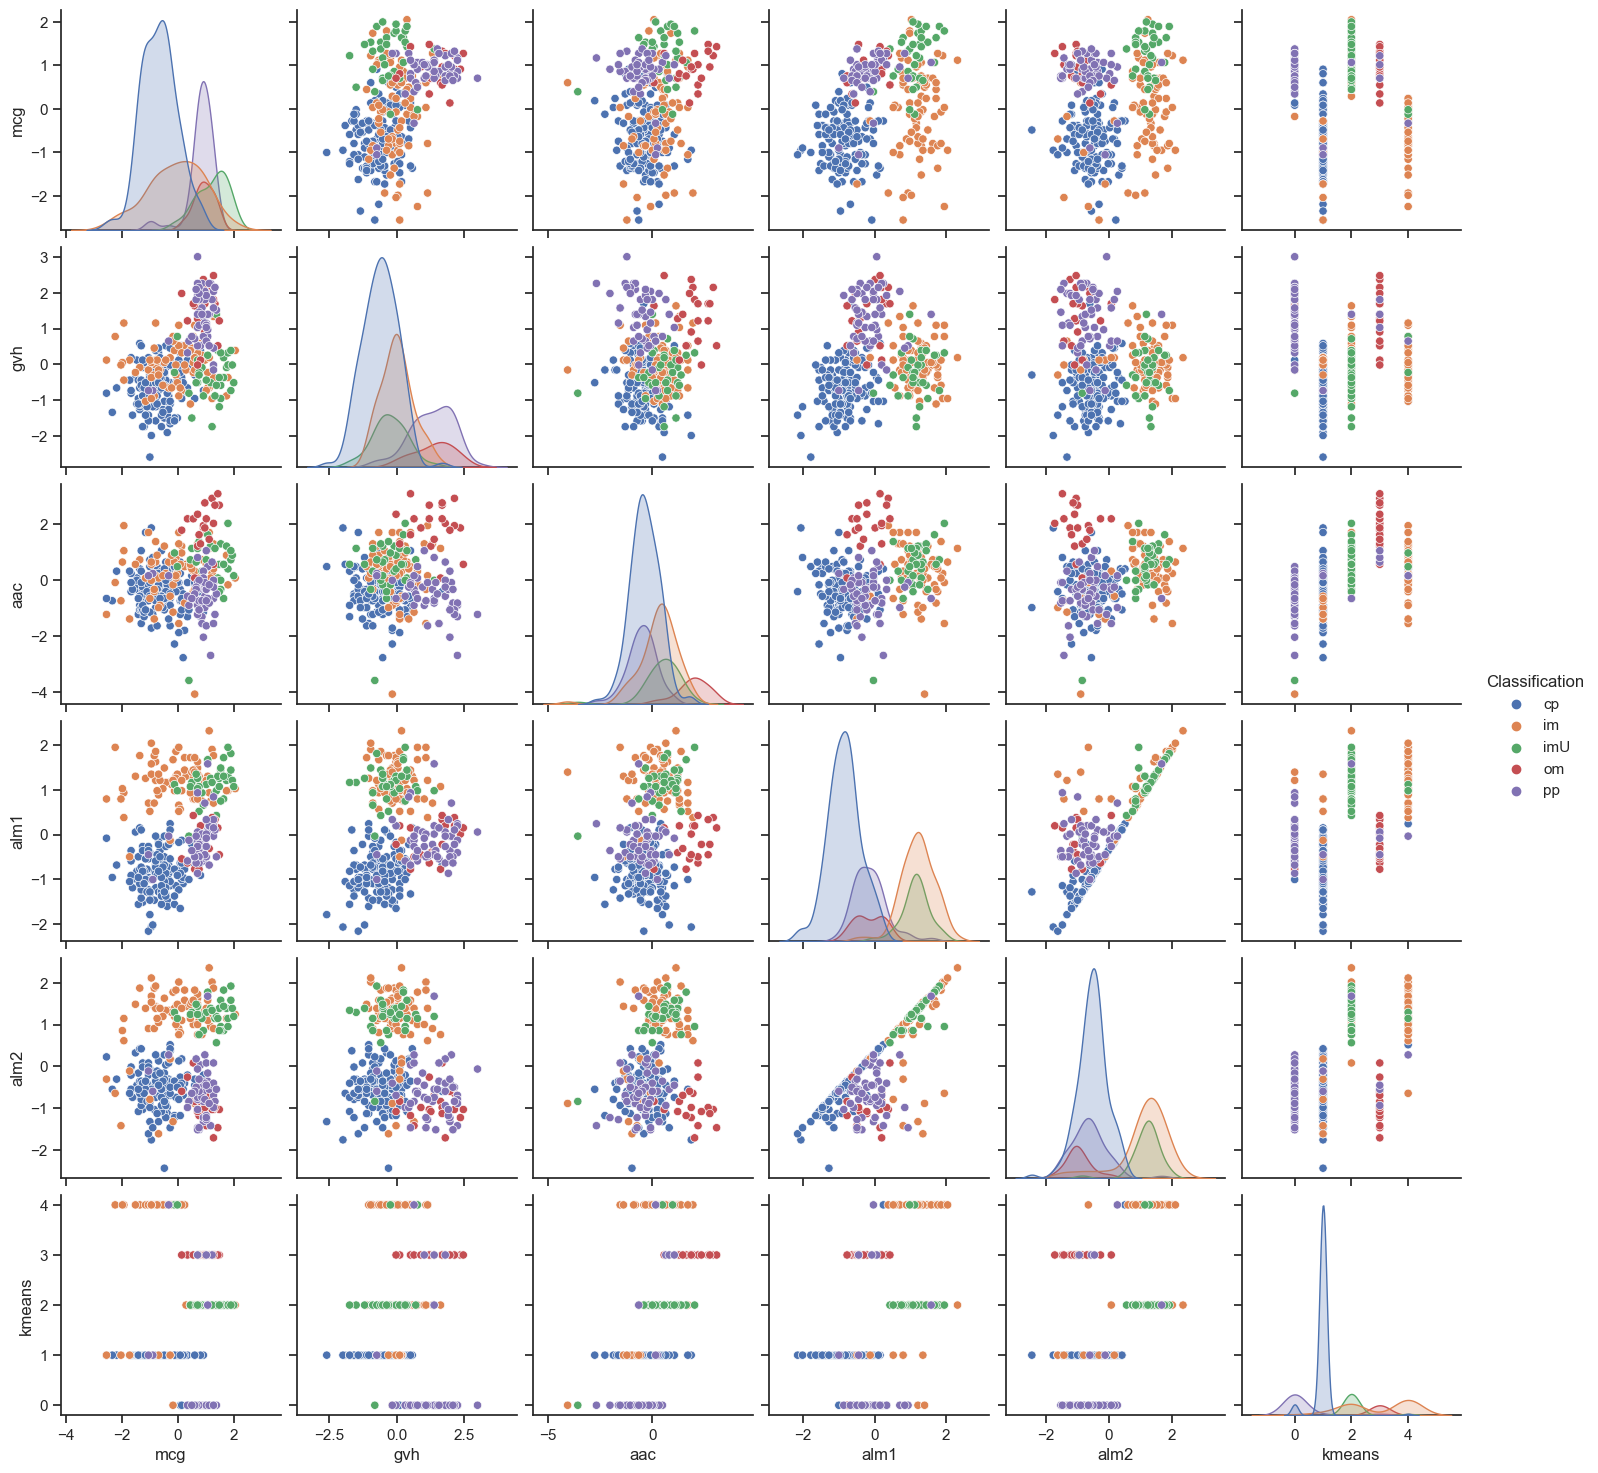

In [18]:
#Visualization of what classifications look like in scatter and histograms
#Visualization of how K-Means algo stacks against classifications
sns.set(style="ticks")

sns.pairplot(data, hue='Classification')

plt.show()

In [19]:
#Metrics of cluster and how well it comes classification
from sklearn.metrics import homogeneity_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

#Comparison to classification
print("Homogeneity Score: " + str(homogeneity_score(labels, km.labels_)))
print("Adjusted Rand Score: " + str(adjusted_rand_score(labels, km.labels_)))
#cluster score
print("Silhouette Score: " + str(silhouette_score(data[features], km.labels_)))

Homogeneity Score: 0.6775750704181834
Adjusted Rand Score: 0.717193109873342
Silhouette Score: 0.34338834232192716


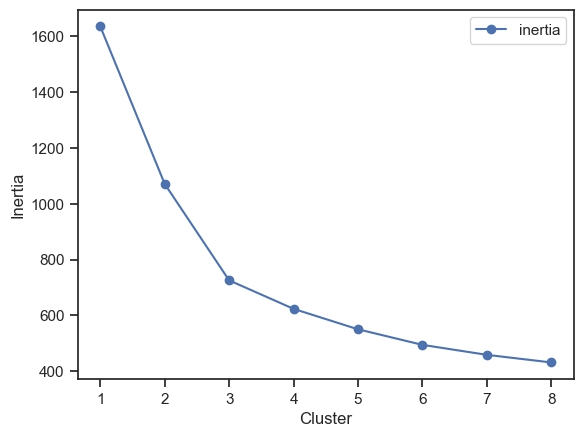

In [20]:
#Finding most optimal cluster count with graph
km_list = []
for cluster in range(1,9):
    km = KMeans(n_clusters=cluster, random_state=42, init='k-means++')
    km = km.fit(data[features])
    
    km_list.append(pd.Series({'clusters':cluster, 'inertia': km.inertia_, 'model':km}))

plot_data = (pd.concat(km_list, axis=1).T[['clusters', 'inertia']].set_index('clusters'))
#Plotting graph to visualize "elbow"
ax = plot_data.plot(marker='o', ls='-')
ax.set(xlabel='Cluster', ylabel='Inertia');

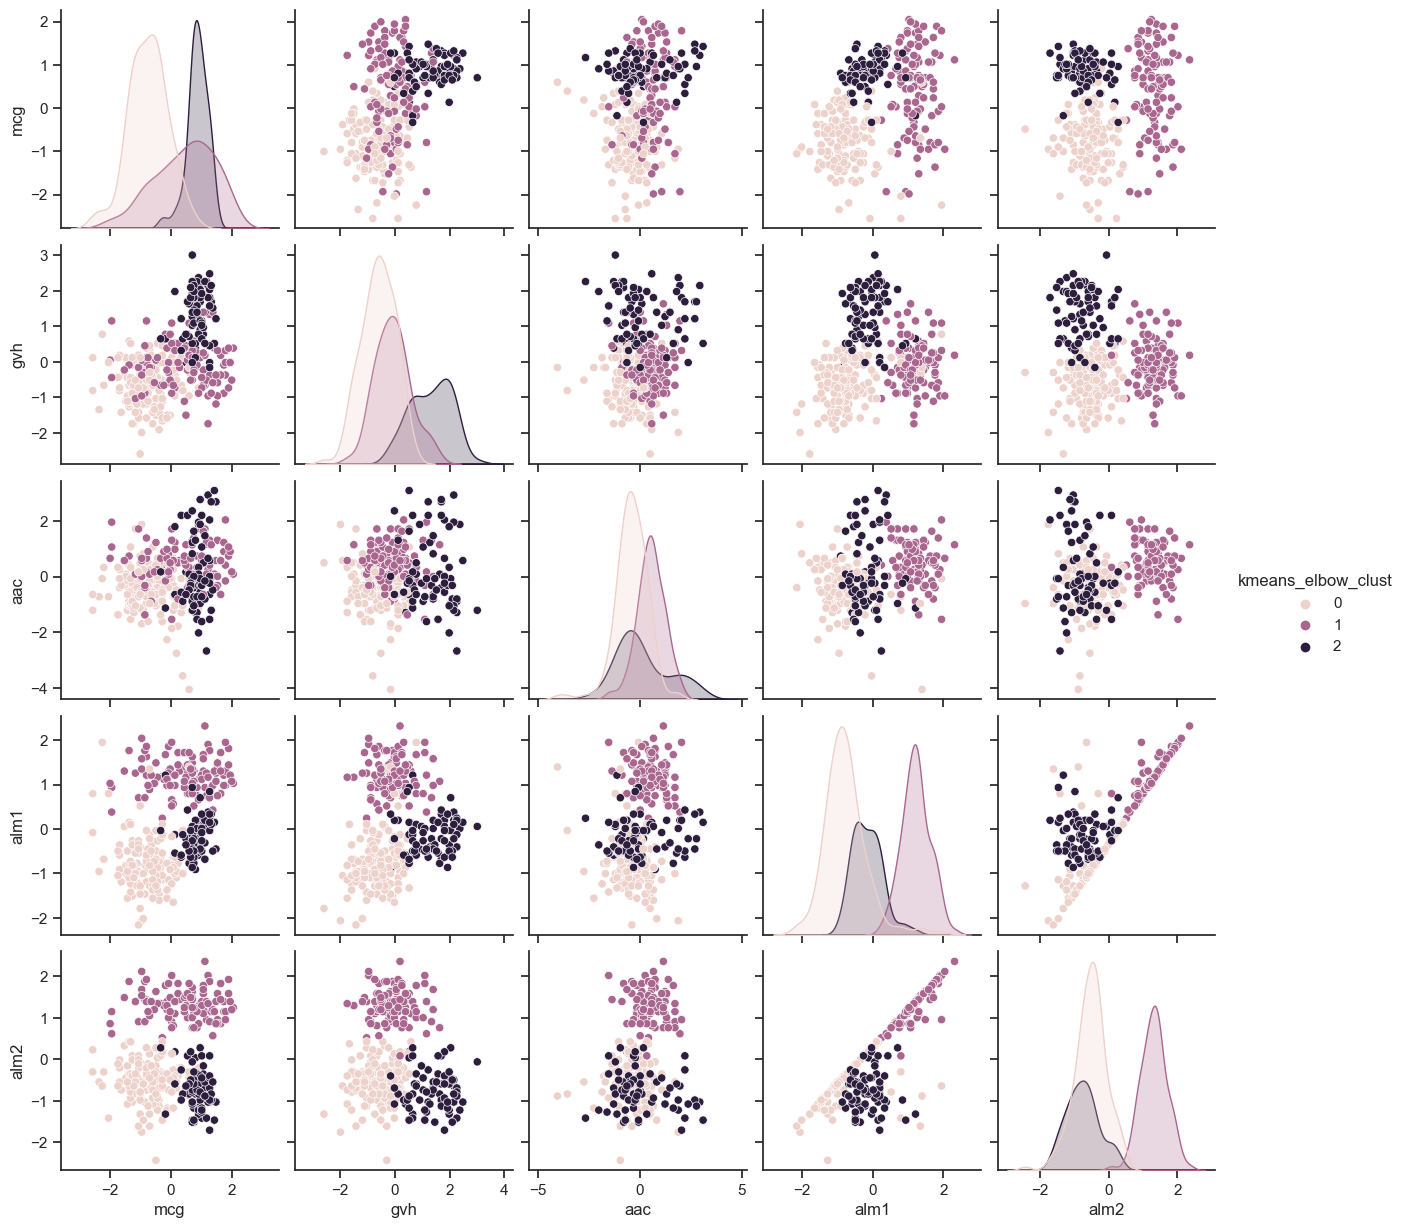

In [21]:
#Generatoing K-Means with elbow cluster number
km_elbow_clust = KMeans(n_clusters=3, random_state=42, init='k-means++')
km_elbow_clust = km_elbow_clust.fit(data[features])

data['kmeans_elbow_clust'] = km_elbow_clust.predict(data[features])

#Graphing results
sns.pairplot(data[[x for x in data.columns if x != 'kmeans']], hue='kmeans_elbow_clust')

In [22]:
#Comparing results 
#Clusters = 5
print("Silhouette Score: " + str(silhouette_score(data[features], km.labels_)))
#Clusters = 3
print("Silhouette Score: " + str(silhouette_score(data[features], km_elbow_clust.labels_))) 

Silhouette Score: 0.24662928631671638
Silhouette Score: 0.39670271437934607
